<a href="https://colab.research.google.com/github/ragul-adhithya/ragul-adhithya/blob/main/SCA_Project_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling
import math
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import Sales Excel File and assigning it to a dataframe

In [ ]:
import io
from google.colab import files
uploaded = files.upload()

Saving Combined_Sales.xlsx to Combined_Sales.xlsx


In [ ]:
df_sales = pd.read_excel(io.BytesIO(uploaded.get('Combined_Sales.xlsx')))
df_sales.head()

,Unnamed: 0,trinvdate,hname,trinvno,trcash,cquant,trquan,trweight,trrate,tramount,advance,lesamt,SUBREGION,REGION
0,0,2018-04-01,CU0000,2,CR,BAG OF 75 KGS,27,2.025,2400.0,64800.0,0.0,0.0,TIRUPUR,TIRUPUR
1,1,2018-04-01,CU0001,3,CR,BAG OF 75 KGS,30,2.250,1920.0,57600.0,0.0,0.0,TIRUPUR,TIRUPUR
2,2,2018-04-01,CU0002,1,CR,BAG OF 75 KGS,25,1.875,2400.0,60000.0,0.0,0.0,TIRUPUR,TIRUPUR
3,3,2018-04-01,CU0003,4,CR,BAG OF 25 KGS,20,0.500,1088.0,21760.0,0.0,0.0,ERODE,ERODE
4,4,2018-04-01,CU0003,4,CR,BAG OF 10 KGS,30,0.300,444.0,13320.0,0.0,0.0,ERODE,ERODE


In [ ]:
uploaded = files.upload()

Saving Combined-Purchase.xlsx to Combined-Purchase.xlsx


In [ ]:
df_purchase = pd.read_excel(io.BytesIO(uploaded.get('Combined-Purchase.xlsx')))
df_purchase.head()

,Unnamed: 0,Date,Customer_ID,Vch Type,Vch No.,Quantity,Rate,Value
0,0,2018-04-01,CU0000,Purchase,1,21900.0,26.15,572685.0
1,1,2018-04-01,CU0001,Purchase,2,21400.0,25.96,555544.0
2,2,2018-04-01,CU0000,Purchase,3,22540.0,26.15,589421.0
3,3,2018-04-02,CU0000,Purchase,4,21440.0,26.62,570733.0
4,4,2018-04-02,CU0000,Purchase,5,21500.0,26.38,567170.0


# Cleaning the Purchase Data

In [ ]:
df_purchase = df_purchase.dropna(how='any')

df_price = df_purchase[['Date','Rate','Quantity']].copy()

df_price['Month'] = pd.DatetimeIndex(df_price['Date']).month_name()
df_price['Year'] = pd.DatetimeIndex(df_price["Date"]).year
df_price["Year"]=df_price["Year"].astype(str)
df_price['Month_N'] = pd.DatetimeIndex(df_price['Date']).month
from datetime import date
df_price['Week']= df_price['Date'].dt.isocalendar().week


df_purchase_d = df_price.groupby(['Year','Date'])['Rate'].mean().reset_index()

df_purchase_d.sort_values(['Year','Date'],inplace = True)

df_purchase_m = df_price.groupby(['Year','Month'])['Rate'].mean().reset_index()

df_purchase_m.sort_values(['Year','Month'],inplace = True)

whole_month_purchase = df_purchase_m[['Rate','Year','Month']]

# Preparing the dataset of Sales

In [ ]:
df_sales.describe()

,Unnamed: 0,trinvno,trquan,trweight,trrate,tramount,advance,lesamt
count,21044.000000,21044.000000,21044.000000,21044.000000,21044.000000,2.104400e+04,19246.000000,19240.000000
mean,3507.144364,1373.172971,139.958468,2.506516,847.765026,9.983202e+04,-1772.533254,309.149324
std,2025.548501,793.948472,146.835283,3.232618,729.668678,1.298507e+05,3420.873231,1200.109867
min,0.000000,1.000000,1.000000,0.005000,16.000000,2.000000e+02,-12750.000000,0.000000
25%,1753.000000,711.000000,30.000000,0.500000,348.000000,1.696000e+04,0.000000,0.000000
50%,3507.000000,1364.000000,100.000000,1.125000,800.000000,4.600000e+04,0.000000,0.000000
75%,5260.250000,2037.000000,200.000000,3.000000,1048.000000,1.224000e+05,0.000000,0.000000
max,7105.000000,2920.000000,3000.000000,30.000000,3600.000000,1.353600e+06,2425.000000,19810.000000


In [ ]:
df_sales.dtypes

Unnamed: 0             int64
trinvdate     datetime64[ns]
hname                 object
trinvno                int64
trcash                object
cquant                object
trquan                 int64
trweight             float64
trrate               float64
tramount             float64
advance              float64
lesamt               float64
SUBREGION             object
REGION                object
dtype: object

In [ ]:
df_sales.isnull().sum() #checking for missing values

Unnamed: 0       0
trinvdate        0
hname            0
trinvno          0
trcash           0
cquant           0
trquan           0
trweight         0
trrate           0
tramount         0
advance       1798
lesamt        1804
SUBREGION        0
REGION           0
dtype: int64

In [ ]:
#here we fill the cells will lesamt and advance as they can have 0

df_sales.fillna(0)

df_sales.isnull().sum()

Unnamed: 0       0
trinvdate        0
hname            0
trinvno          0
trcash           0
cquant           0
trquan           0
trweight         0
trrate           0
tramount         0
advance       1798
lesamt        1804
SUBREGION        0
REGION           0
dtype: int64

In [ ]:
#renaming the columns for sales dataframe
df_sales = df_sales.rename(columns = {'trinvdate':'Date','hname':'Party','trinvno':'No','trcash':'Cash/Credit',\
                 'cquant':'Bag','trquan':'Qty','trweight':'Weight', \
                     'trrate':'Price','tramount': 'Value', 'lesamt':'less','salesacamt':'Net_Value'})


In [ ]:

#here we ignore all the cash sales due to business implications

df_sales = df_sales.loc[df_sales['Cash/Credit'] == "CR"]
df_sales.groupby('Cash/Credit').sum() # checking that only Credit Columns are taken into consideration

,Unnamed: 0,No,Qty,Weight,Price,Value,advance,less
Cash/Credit,,,,,,,,
CR,63425233,24798789,2915478,52063.444,15134232.8,2.079684e+09,-34079175.0,5945783.0


In [ ]:
df_sales.groupby(['Bag'])['Price'].mean()

Bag
BAG OF 1 KGS        41.506361
BAG OF 10 KGS      412.128518
BAG OF 100 KGS     626.666667
BAG OF 25 KGS      988.051855
BAG OF 5 KGS       206.575784
BAG OF 50 KGS     2159.219048
BAG OF 75 KGS     2834.341836
BAGS               736.000000
Name: Price, dtype: float64

In [ ]:
# PANDAS PROFILING - TAKE # OFF FOR RUNNING
#profile = pandas_profiling.ProfileReport(df_sales)

#file_name = "pandas_profiling_report.html"
#profile.to_file('sales')


In [ ]:
Weight = df_sales['Bag'].str.split(' ', n=4, expand = True)
df_sales['Unit_weight'] = Weight[2]
df_sales['Unit_weight'] = df_sales['Unit_weight'].astype(float)

In [ ]:

df_sales['less'] = df_sales['less'].astype(float)

df_sales['Discount'] = df_sales['less'] + abs(df_sales['advance'])

df_sales['Unit_Price'] = df_sales['Price']/df_sales['Unit_weight']


In [ ]:
# Calculating the Month, Year, Day, Week, Month Year and Weekend
df_sales['Month'] = pd.DatetimeIndex(df_sales['Date']).month_name()
df_sales['Year'] = pd.DatetimeIndex(df_sales["Date"]).year
df_sales["Day"] =pd.DatetimeIndex(df_sales["Date"]).dayofweek
df_sales["Year"]=df_sales["Year"].astype(str)
df_sales['Month_N'] = pd.DatetimeIndex(df_sales['Date']).month

from datetime import date
df_sales['Week']= df_sales['Date'].dt.isocalendar().week

df_sales["Month_Year"]=df_sales["Month"] + df_sales["Year"]

df_sales["Weekend"]=((df_sales["Day"]== 5) | (df_sales["Day"]==6)).astype(int)


In [ ]:
# Calculating Adjusted Discount based on weight of commodity in the invoice and calculting new Unit Price with Discount
df_group = df_sales.groupby(['Year','No']).agg(sum_w = ('Weight',sum)).reset_index()

df_sales.sort_values(['Year','No'])

df_sales = pd.merge(df_sales,df_group,on=['Year','No'],how='left')

In [ ]:
df_sales['Adj_Dis'] = df_sales['Weight']/df_sales['sum_w']*df_sales['Discount']


df_sales['Unit_Price_Dis'] = round(df_sales['Unit_Price']-(df_sales['Adj_Dis']/df_sales['Weight']),2)
#df.loc[0:10,['Price_discount','Unit_Price']]

# Time Series Sales Analysis

In [ ]:
#Comverting the Data into Daily Sales Data of Weight of commodity sold

In [ ]:

df_daily = df_sales.groupby('Date').agg(sum_d=('Weight',sum)).sort_values(['Date']).sort_values('Date').reset_index()

df_daily = df_daily.rename(columns={'sum_d':'Count'})
#Printing head

print(df_daily.shape)

(1037, 2)


In [ ]:
df_daily['Week']= df_daily['Date'].dt.isocalendar().week
df_daily['Year'] = pd.DatetimeIndex(df_daily["Date"]).year
df_daily['Month'] = pd.DatetimeIndex(df_daily['Date']).month
df_daily['Week']= df_daily['Date'].dt.isocalendar().week

In [ ]:
#%% COnverting Daily Data to Monthly Data

df_month = df_daily.groupby(['Year','Month'])['Count'].sum().reset_index()

df_month.sort_values(['Year','Month'], inplace = True)

whole_month_sales = df_month['Count']

In [ ]:
df_month.tail()

,Year,Month,Count
31,2020,11,1095.050
32,2020,12,1710.865
33,2021,1,1292.975
34,2021,2,1642.175
35,2021,3,1623.000


In [ ]:
# Here we create two dataframe. One dataframe to store all the forecaste values and other for errors
df_forecast = pd.DataFrame(columns=["S.No","seasonalNaiveForecast","movingAvg","Exponential_Smoothing","Holt_Winters","ARIMA","Random_Forest"])
df_errors = pd.DataFrame(columns=["Method","RMSE","MAPE","MSE"])

*Defining functions for Seasonal Naive Forecasting, Moving Average and Exponential Smoothing. Here we take Seasonal Naive Forecasting as our base model.*


> Indented block
**bold text**

---



In [ ]:
whole_month_sales= list(whole_month_sales)
n_periods = len(whole_month_sales)

# defining the naive forecast function
def seasonalNaiveForecast(sales, t, s):
  return sales[t-s]

# defininf the Moving Average Function
def movingAvg(sales, t, k):
    return sum(sales[t-k:t]) / k

# defining the Exponential Smoothing Function

def exponentialSmoothing(sales, t, alpha):
    exp_forecast = []
    exp_forecast.append(sales[0]) # assume the initial forecast (index 0) = actual demand in the same period
    for i in range(1, t+1):
      exp_forecast.append(alpha*sales[i-1]+(1-alpha)*exp_forecast[i-1])
    return  exp_forecast[t]



**Error Terms fucntions - MSE, MAPE AND RMSE**

In [125]:
# MSE
def MSE(forecast, real_demand):
    sum_mse = 0
    n_periods = len(forecast)
    for t in range(n_periods):
        sum_mse += (real_demand[t] - forecast[t]) ** 2
    return sum_mse/n_periods


# MAPE
def MAPE(forecast, real_demand):
    n_periods = len(forecast)
    mape_t = [abs(real_demand[t] - forecast[t])/real_demand[t] for t in range(n_periods)] 
    return sum(mape_t)/n_periods
#RMSE
def RMSE(forecast,real_demand):
  rmse = mean_squared_error(forecast, real_demand)
  return rmse


### Seasonal Naive

In [129]:

best_s = 0 # initialize the initial value of best s
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for s in range(2,12,2):
  #print("s = ", s)
  whole_month_sales_fcst_seasonnaive = [seasonalNaiveForecast(whole_month_sales, t, s) for t in range(29, 36)]
  whole_month_sales_fcst_seasonnaive_mape = MAPE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])
  #print("MAPE :", whole_month_sales_fcst_seasonnaive_mape)
  if whole_month_sales_fcst_seasonnaive_mape < best_mape: # keep track of the best s
    best_s = s # set the new best_s
    best_mape = whole_month_sales_fcst_seasonnaive_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best seasonality length s = ", best_s)
whole_month_sales_fcst_seasonnaive = [seasonalNaiveForecast(whole_month_sales, t, best_s) for t in range(29, 36)]
whole_month_sales_fcst_seasonnaive_mse = MSE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])
whole_month_sales_fcst_seasonnaive_mape = MAPE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])
whole_month_sales_fcst_seasonnaive_rmse = RMSE(whole_month_sales_fcst_seasonnaive, whole_month_sales[29:])

print("add results to the dictionary for the method: ", fcst_names[1])
fcst_results[fcst_names[1]] = {'Forecast':whole_month_sales_fcst_seasonnaive, 'MSE':whole_month_sales_fcst_seasonnaive_mse, 'MAPE':whole_month_sales_fcst_seasonnaive_mape}
print(fcst_results)

df_forecast["seasonalNaiveForecast"] = whole_month_sales_fcst_seasonnaive

df_errors.loc["seasonalNaiveForecast","MAPE"] = whole_month_sales_fcst_seasonnaive_mape
df_errors.loc["seasonalNaiveForecast","RMSE"] = whole_month_sales_fcst_seasonnaive_rmse
df_errors.loc["seasonalNaiveForecast","MSE"] = whole_month_sales_fcst_seasonnaive_mse


best seasonality length s =  10
add results to the dictionary for the method:  SeasonNaive
{'Naive': {'Forecast': [1237.825, 1449.83, 1570.53, 1095.05, 1710.865, 1292.975, 1642.175], 'MSE': 137394.90391071432, 'MAPE': 0.1595485215814425}, 'SeasonNaive': {'Forecast': [1437.175, 1679.625, 1111.975, 1545.175, 903.025, 1729.975, 1133.175], 'MSE': 62785.69612857143, 'MAPE': 0.12105046738157765}, 'MovingAvg': {'Forecast': [1377.475, 1321.4460000000001, 1408.917, 1329.152, 1412.82, 1423.85, 1462.319], 'MSE': 57048.91522142856, 'MAPE': 0.1489827978164803}, 'Exp.Smooth': {'Forecast': [1385.4221932407202, 1391.8629739166481, 1409.7296765249835, 1378.261708872485, 1411.5220379852367, 1399.6673341867129, 1423.9181007680415], 'MSE': 51173.64152325976, 'MAPE': 0.14314025600836744}}


### Moving Average

In [ ]:

best_k = 0 # initialize the initial value of best k
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for k in range(2,6):
  #print("k = ", k)
  whole_month_sales_fcst_movingavg = [movingAvg(whole_month_sales, t, k) for t in range(29, 36)]
  whole_month_sales_fcst_movingavg_mape = MAPE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])
  if whole_month_sales_fcst_movingavg_mape < best_mape: # keep track of the best parameter
    best_k = k # set the new best_k
    best_mape = whole_month_sales_fcst_movingavg_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best lookback length k = ", best_k)
whole_month_sales_fcst_movingavg = [movingAvg(whole_month_sales, t, best_k) for t in range(29, 36)]
whole_month_sales_fcst_movingavg_mse = MSE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])
whole_month_sales_fcst_movingavg_mape = MAPE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])
whole_month_sales_fcst_movingavg_rmse = RMSE(whole_month_sales_fcst_movingavg, whole_month_sales[29:])


print("add results to the dictionary for the method: ", fcst_names[2])
fcst_results[fcst_names[2]] = {'Forecast':whole_month_sales_fcst_movingavg, 'MSE':whole_month_sales_fcst_movingavg_mse, 'MAPE':whole_month_sales_fcst_movingavg_mape}
print(fcst_results)

df_forecast["MovingAvging"] = whole_month_sales_fcst_movingavg

df_errors.loc["MovingAvging","MAPE"] = whole_month_sales_fcst_movingavg_mape
df_errors.loc["MovingAvging","RMSE"] = whole_month_sales_fcst_movingavg_rmse
df_errors.loc["MovingAvging","MSE"] = whole_month_sales_fcst_movingavg_mse



best lookback length k =  5
add results to the dictionary for the method:  MovingAvg
{'Naive': {'Forecast': [1237.825, 1449.83, 1570.53, 1095.05, 1710.865, 1292.975, 1642.175], 'MSE': 137394.90391071432, 'MAPE': 0.1595485215814425}, 'SeasonNaive': {'Forecast': [1437.175, 1679.625, 1111.975, 1545.175, 903.025, 1729.975, 1133.175], 'MSE': 62785.69612857143, 'MAPE': 0.12105046738157765}, 'MovingAvg': {'Forecast': [1377.475, 1321.4460000000001, 1408.917, 1329.152, 1412.82, 1423.85, 1462.319], 'MSE': 57048.91522142856, 'MAPE': 0.1489827978164803}}


### Exponential Smoothing

In [ ]:

best_alpha = 0 # initialize the initial value of best alpha
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for alpha in [0.1*i for i in range(1,10)]: 
  whole_month_sales_fcst_expsmooth = [exponentialSmoothing(whole_month_sales, t, alpha) for t in range(29, 36)]
  whole_month_sales_fcst_expsmooth_mape = MAPE(whole_month_sales_fcst_expsmooth, whole_month_sales[26:])
  if whole_month_sales_fcst_expsmooth_mape < best_mape: # keep track of the best parameter
    best_alpha = alpha # set the new best parameter
    best_mape = whole_month_sales_fcst_expsmooth_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best alpha = ", best_alpha)
whole_month_sales_fcst_expsmooth = [exponentialSmoothing(whole_month_sales, t, best_alpha) for t in range(29, 36)]
whole_month_sales_fcst_expsmooth_mse = MSE(whole_month_sales_fcst_expsmooth, whole_month_sales[29:])
whole_month_sales_fcst_expsmooth_mape = MAPE(whole_month_sales_fcst_expsmooth, whole_month_sales[29:])
whole_month_sales_fcst_expsmooth_rmse = RMSE(whole_month_sales_fcst_expsmooth, whole_month_sales[29:])

print("ExponentialSmoothing Results: ", fcst_names[3])
print('Forecast', whole_month_sales_fcst_expsmooth)
print('MSE:',round(whole_month_sales_fcst_expsmooth_mse), 'MAPE:',round(whole_month_sales_fcst_expsmooth_mape*100),'RMSE:', round(whole_month_sales_fcst_expsmooth_rmse))

  
df_forecast["Exponential_Smoothing"] = whole_month_sales_fcst_expsmooth

df_errors.loc["Exponential_Smoothing","MAPE"] = whole_month_sales_fcst_expsmooth_mape
df_errors.loc["Exponential_Smoothing","RMSE"] = whole_month_sales_fcst_expsmooth_rmse
df_errors.loc["Exponential_Smoothing","MSE"] = whole_month_sales_fcst_expsmooth_mse

best alpha =  0.1
ExponentialSmoothing Results:  Exp.Smooth
Forecast [1385.4221932407202, 1391.8629739166481, 1409.7296765249835, 1378.261708872485, 1411.5220379852367, 1399.6673341867129, 1423.9181007680415]
MSE: 51174 MAPE: 14 RMSE: 51174


### Holt Winters

In [136]:

n = len(whole_month_sales)
print(round(n*0.8))

train = whole_month_sales[0:(round(n*0.8))]
test = whole_month_sales[(round(n*0.8)):]

best_i = 0
best_mape = 1.0

for i in range (2,13):
    fit1 = ExponentialSmoothing(train ,seasonal_periods= i,trend='add', seasonal='add').fit()
    y_hat = list(fit1.forecast(len(test)))
    Exp_sales_mape = MAPE(y_hat,test)
    if Exp_sales_mape < best_mape: # keep track of the best s
      best_i = i # set the new best_s
      best_mape = Exp_sales_mape # set the new best_mape

Exp_model_sales = ExponentialSmoothing(train ,seasonal_periods= best_i,trend='add', seasonal='add').fit()
Exp_forecast_sales = list(Exp_model_sales.forecast(len(test)))
Exp_sales_mape = MAPE(Exp_forecast_sales,test)
Exp_sales_mse = MSE(Exp_forecast_sales,test)
Exp_sales_rmse = RMSE(Exp_forecast_sales,test)

df_forecast["Holt_Winters"] = Exp_forecast_sales

df_errors.loc["Holt_Winters","MAPE"] = Exp_sales_mape
df_errors.loc["Holt_Winters","RMSE"] = Exp_sales_rmse
df_errors.loc["Holt_Winters","MSE"] = Exp_sales_mse

29


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

In [137]:
print("Holt Winters Results: ", fcst_names[3])
print('Forecast', Exp_forecast_sales)
print('MSE:',round(Exp_sales_mse), 'MAPE:',round(Exp_sales_mape*100),'RMSE:', round(Exp_sales_rmse))

  

Holt Winters Results:  Exp.Smooth
Forecast [1505.2668556844837, 1371.1714965684112, 1241.897655953853, 1419.4686786607203, 1288.061948384434, 1483.1837002249063, 1349.0883411088337]
MSE: 35660 MAPE: 11 RMSE: 35660


In [ ]:
#%%% ADF Test

from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(train, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')



ADF Statistic: -7.07277187910589
p-value: 4.888570251018919e-10
Critial Values:
   1%, -3.6889256286443146
Critial Values:
   5%, -2.9719894897959187
Critial Values:
   10%, -2.6252957653061224


***Since, the p - value is less than 0.05, we can conclude that the data is stationary and the d value in ARIMA is 0.***

---

**bold text**

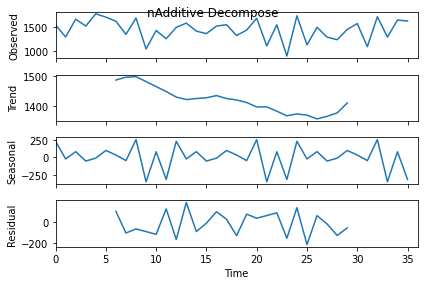

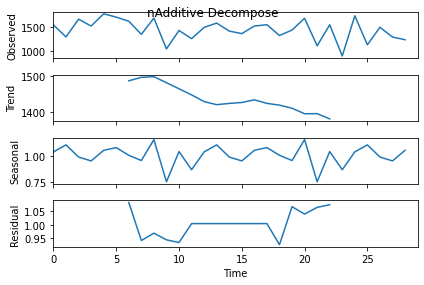

In [ ]:
# Additive and Multiple Decomposition
add_result = seasonal_decompose(whole_month_sales, model='additive',freq=12)
add_result.plot().suptitle('nAdditive Decompose', fontsize=12)
# Multiplicative Decomposition 
mul_result = seasonal_decompose(train, model='multiplicative',freq=12)
mul_result.plot().suptitle('nAdditive Decompose', fontsize=12)
plt.show()
decomposition = list([add_result.seasonal, add_result.trend, add_result.resid, add_result.observed])
new_df_add = ['seasoanilty', 'trend', 'residual', 'actual_values']


### ARIMA

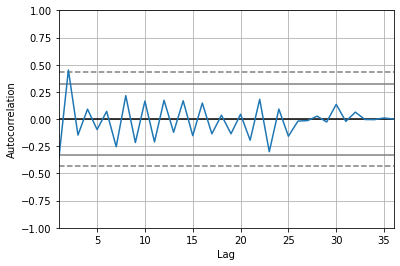

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


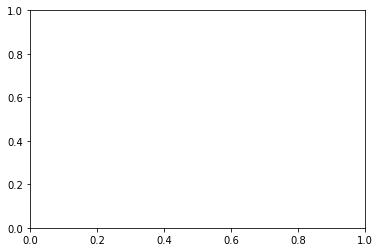

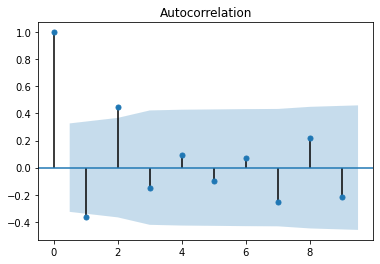

<Figure size 432x288 with 0 Axes>

In [ ]:
#%%% ACF and PCF Polts
from pandas.plotting import autocorrelation_plot
pd.plotting.autocorrelation_plot(whole_month_sales)
plt.show()

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure()
ax1 = fig.add_subplot()
fig = sm.graphics.tsa.plot_acf(whole_month_sales,lags=9)
ax2 = fig.add_subplot()
fig = sm.graphics.tsa.plot_pacf(whole_month_sales,lags=9)
plt.clf()


Based on the ACF and PCF Plots, we can determine that the best values for P and Q of ARIMA model is 2 and 2, as the line goes above the blue line.

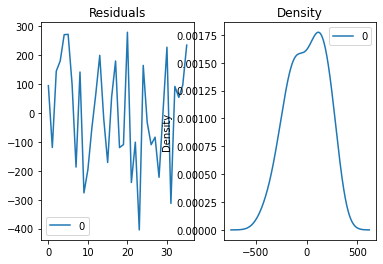

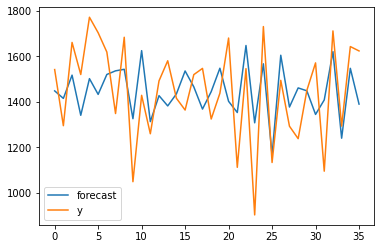

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   36
Model:                     ARMA(2, 2)   Log Likelihood                -238.235
Method:                       css-mle   S.D. of innovations            179.701
Date:                Tue, 05 Apr 2022   AIC                            488.470
Time:                        03:51:47   BIC                            497.971
Sample:                             0   HQIC                           491.787
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1447.6426     36.303     39.877      0.000    1376.491    1518.795
ar.L1.y       -0.1644      0.513     -0.321      0.751      -1.169       0.840
ar.L2.y        0.2049      0.370      0.553      0.5

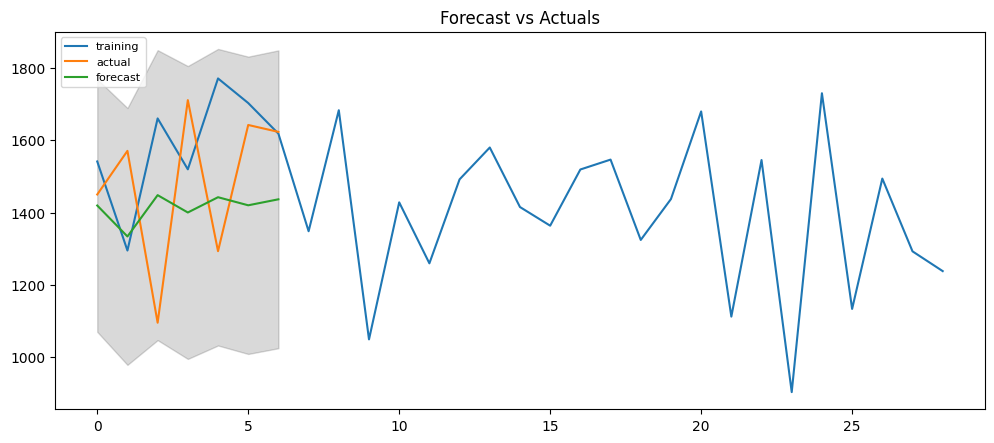

234.4262859276187
14.879443508159481
54955.68353381764


<Figure size 432x288 with 0 Axes>

In [93]:

#%%% ARIMA Model
from statsmodels.tsa.arima_model import ARIMA


# 2,0,2 ARIMA Model - Based on ACF and PCF Plot
model = ARIMA(whole_month_sales, order=(2,0,2))
model_fit = model.fit()

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

model_fit.plot_predict(dynamic=False)
plt.show()

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(2, 0, 2))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_demand = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])
print(model_fit.summary())

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series_demand, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
plt.clf()

rmse_sales_arima = sqrt(mean_squared_error(test, fc_series_demand))
print(rmse_sales_arima)

mape_sales_arima = mape(test, fc_series_demand)
print(mape_sales_arima)

mse_sales_arima = MSE(fc_series_demand,test)
print(mse_sales_arima)
df_forecast["ARIMA"] = fc

df_errors.loc["ARIMA","MAPE"] = mape_sales_arima
df_errors.loc["ARIMA","RMSE"] = rmse_sales_arima
df_errors.loc["ARIMA","MSE"] = mse_sales_arima



### Random Forest

In [117]:

df_random = df_sales

df_random.isnull().sum()

df_random = df_random.dropna()
#['Value','advance','less','Qty','Net Value','Unit Weight','Unit Price','Month_N','Month_Year','sum_w','Discount']]

df_random = df_random[['Date','Year','Month','Cash/Credit','Bag','Weight','Adj_Dis','Unit_Price_Dis']]

df_1 = df_random.groupby(['Year','Month','Bag']).agg(sum_weight=('Weight',sum),Discount=('Adj_Dis','mean'),Unit_Rate = ('Unit_Price_Dis','mean'),Bag_count=('Bag','count')).reset_index()

df_dummies = pd.get_dummies(df_1[['Bag']])
df_dummies.head()

df_rand = df_1.join(df_dummies)

df_rand = df_rand.groupby(['Month','Year']).agg({'sum_weight':'sum', 'Discount':'mean', 'Unit_Rate':'mean'}).reset_index()

df_rand.sort_values(['Year','Month'],inplace =True)

df_rand = pd.merge(df_rand, whole_month_purchase,on=['Year','Month'] ,how = 'left')

del df_rand['Month']
del df_rand['Year']
#del df_rand['Product']
#del df_rand['Bag']

labels = np.array(df_rand['sum_weight'])
feature_list = list(df_rand.columns.values)
                          
del df_rand['sum_weight']
df_rand = np.array(df_rand)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_rand, labels, test_size = 0.2, random_state = 1000)



print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)



# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions_demand_rf= rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions_demand_rf - test_labels)
# Print out the mean absolute error (mae)
mse_sales_rf = MSE(test_labels,predictions_demand_rf)
print("MSE of Random Forest Demand: ",mse_sales_rf)
mape_sales_rf = MAPE(test_labels,predictions_demand_rf)
print(mape_sales_rf*100)

rmse_sales_rf = math.sqrt(mean_squared_error(test_labels, predictions_demand_rf))
print('RMSE of Random Forest =',round(rmse_sales_rf))





Training Features Shape: (28, 3)
Training Labels Shape: (28,)
Testing Features Shape: (8, 3)
Testing Labels Shape: (8,)
MSE of Random Forest Demand:  24733.268199169746
8.490332608433883
RMSE of Random Forest = 157


Initating GRID search to find the best parameter value for the Random Forest
**bold text**



In [118]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
# Create a based model
rf = RandomForestRegressor()

#Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
grid_search.best_params_


best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 154.3574.
Accuracy = 89.82%.
Fitting 3 folds for each of 288 candidates, totalling 864 fits


KeyboardInterrupt: ignored

In [115]:
predictions_demand_rf = best_grid.predict(test_features)
mape_sales_rf = MAPE(predictions_demand_rf,test_labels)
rmse_sales_rf = math.sqrt(mean_squared_error(test_labels, predictions_demand_rf))
mse_sales_rf = MSE(predictions_demand_rf,test_labels)

In [116]:
df_forecast["Random_Forest"] = predictions_demand_rf

df_errors.loc["Random_Forest","MAPE"] = mape_sales_rf
df_errors.loc["Random_Forest","RMSE"] = rmse_sales_rf
df_errors.loc["Random_Forest","MSE"] = mse_sales_rf

ValueError: ignored

# Purchase Price Predictions

In [119]:
# Here we create two dataframe. One dataframe to store all the forecaste values and other for errors
df_forecast_price = pd.DataFrame(columns=["S.No","seasonalNaiveForecast","Exponential_Smoothing","Holt_Winters","ARIMA","SARIMAX","Random_Forest"])
df_errors_price = pd.DataFrame(columns=["Method","RMSE","MAPE","MSE"])

In [131]:
purchase = df_purchase_d

purchase = list(df_purchase_d['Rate'])

n = len(purchase)
print(n)
print(round(n*0.8))

train_price = purchase[0:(round(n*0.8))]
test_price = purchase[(round(n*0.8)):]


891
713


## Seasonal Navie Forecasting

In [132]:

best_s = 0 # initialize the initial value of best s
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for s in range(2,12,2):
  #print("s = ", s)
  purchase_fcst_seasonnaive = [seasonalNaiveForecast(purchase, t, s) for t in range(713, 891)]
  purchase_fcst_seasonnaive_mape = MAPE(purchase_fcst_seasonnaive, purchase[713:])
  #print("MAPE :", purchase_fcst_seasonnaive_mape)
  if purchase_fcst_seasonnaive_mape < best_mape: # keep track of the best s
    best_s = s # set the new best_s
    best_mape = purchase_fcst_seasonnaive_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best seasonality length s = ", best_s)
purchase_fcst_seasonnaive = [seasonalNaiveForecast(purchase, t, best_s) for t in range(713, 891)]
purchase_fcst_seasonnaive_mse = MSE(purchase_fcst_seasonnaive, purchase[713:])
purchase_fcst_seasonnaive_mape = MAPE(purchase_fcst_seasonnaive, purchase[713:])
purchase_fcst_seasonnaive_rmse = RMSE(purchase_fcst_seasonnaive, purchase[713:])

print("add results to the dictionary for the method: ", fcst_names[1])
fcst_results[fcst_names[1]] = {'Forecast':purchase_fcst_seasonnaive, 'MSE':purchase_fcst_seasonnaive_mse, 'MAPE':purchase_fcst_seasonnaive_mape}
print(fcst_results)

df_forecast_price["seasonalNaiveForecast"] = purchase_fcst_seasonnaive

df_errors_price.loc["seasonalNaiveForecast","MAPE"] = purchase_fcst_seasonnaive_mape
df_errors_price.loc["seasonalNaiveForecast","RMSE"] = purchase_fcst_seasonnaive_rmse
df_errors_price.loc["seasonalNaiveForecast","MSE"] = purchase_fcst_seasonnaive_mse




best seasonality length s =  2
add results to the dictionary for the method:  SeasonNaive
{'Naive': {'Forecast': [1237.825, 1449.83, 1570.53, 1095.05, 1710.865, 1292.975, 1642.175], 'MSE': 137394.90391071432, 'MAPE': 0.1595485215814425}, 'SeasonNaive': {'Forecast': [19.125, 19.39818181818182, 19.59, 19.66, 19.27625, 20.47, 20.5825, 21.85, 21.744999999999997, 21.78, 21.78, 21.67, 21.7, 21.23, 21.4025, 21.253333333333334, 21.48, 21.253333333333334, 21.31, 20.563333333333333, 20.631666666666668, 21.028, 21.466, 21.5, 21.426666666666666, 21.413333333333338, 21.5975, 21.490000000000002, 21.456666666666667, 21.44333333333333, 21.69, 21.484, 21.253333333333334, 21.24125, 20.952, 20.501666666666665, 20.495, 21.37, 20.773333333333333, 20.361428571428572, 20.855, 21.872, 20.265, 21.67, 21.67, 21.67, 21.55, 19.78, 20.54, 21.649999999999995, 21.636, 20.945, 21.608, 21.064999999999998, 21.125999999999998, 21.14, 20.83111111111111, 21.294999999999998, 21.55, 21.64, 21.0, 21.49142857142857, 20.9575, 

## Moving Average

In [133]:

best_k = 0 # initialize the initial value of best k
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for k in range(2,6):
  #print("k = ", k)
  purchase_fcst_movingavg = [movingAvg(purchase, t, k) for t in range(713, 891)]
  purchase_fcst_movingavg_mape = MAPE(purchase_fcst_movingavg, purchase[713:])
  if purchase_fcst_movingavg_mape < best_mape: # keep track of the best parameter
    best_k = k # set the new best_k
    best_mape = purchase_fcst_movingavg_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best lookback length k = ", best_k)
purchase_fcst_movingavg = [movingAvg(purchase, t, best_k) for t in range(713, 891)]
purchase_fcst_movingavg_mse = MSE(purchase_fcst_movingavg, purchase[713:])
purchase_fcst_movingavg_mape = MAPE(purchase_fcst_movingavg, purchase[713:])
purchase_fcst_movingavg_rmse = RMSE(purchase_fcst_movingavg, purchase[713:])


print("add results to the dictionary for the method: ", fcst_names[2])
fcst_results[fcst_names[2]] = {'Forecast':purchase_fcst_movingavg, 'MSE':purchase_fcst_movingavg_mse, 'MAPE':purchase_fcst_movingavg_mape}
print(fcst_results)

df_forecast_price["MovingAvging"] = purchase_fcst_movingavg

df_errors_price.loc["MovingAvging","MAPE"] = purchase_fcst_movingavg_mape
df_errors_price.loc["MovingAvging","RMSE"] = purchase_fcst_movingavg_rmse
df_errors_price.loc["MovingAvging","MSE"] = purchase_fcst_movingavg_mse




best lookback length k =  2
add results to the dictionary for the method:  MovingAvg
{'Naive': {'Forecast': [1237.825, 1449.83, 1570.53, 1095.05, 1710.865, 1292.975, 1642.175], 'MSE': 137394.90391071432, 'MAPE': 0.1595485215814425}, 'SeasonNaive': {'Forecast': [19.125, 19.39818181818182, 19.59, 19.66, 19.27625, 20.47, 20.5825, 21.85, 21.744999999999997, 21.78, 21.78, 21.67, 21.7, 21.23, 21.4025, 21.253333333333334, 21.48, 21.253333333333334, 21.31, 20.563333333333333, 20.631666666666668, 21.028, 21.466, 21.5, 21.426666666666666, 21.413333333333338, 21.5975, 21.490000000000002, 21.456666666666667, 21.44333333333333, 21.69, 21.484, 21.253333333333334, 21.24125, 20.952, 20.501666666666665, 20.495, 21.37, 20.773333333333333, 20.361428571428572, 20.855, 21.872, 20.265, 21.67, 21.67, 21.67, 21.55, 19.78, 20.54, 21.649999999999995, 21.636, 20.945, 21.608, 21.064999999999998, 21.125999999999998, 21.14, 20.83111111111111, 21.294999999999998, 21.55, 21.64, 21.0, 21.49142857142857, 20.9575, 21.11

## Exponential Smoothing

In [134]:

best_alpha = 0 # initialize the initial value of best alpha
best_mape = 1.0 # initialize the initial value of MAPE (at the maximum 100%)

for alpha in [0.1*i for i in range(1,10)]: 
  purchase_fcst_expsmooth = [exponentialSmoothing(purchase, t, alpha) for t in range(713, 891)]
  purchase_fcst_expsmooth_mape = MAPE(purchase_fcst_expsmooth, purchase[26:])
  if purchase_fcst_expsmooth_mape < best_mape: # keep track of the best parameter
    best_alpha = alpha # set the new best parameter
    best_mape = purchase_fcst_expsmooth_mape # set the new best_mape

# we compute again the corresponding forecasts and results based on the best parameter
print("best alpha = ", best_alpha)
purchase_fcst_expsmooth = [exponentialSmoothing(purchase, t, best_alpha) for t in range(713, 891)]
purchase_fcst_expsmooth_mse = MSE(purchase_fcst_expsmooth, purchase[713:])
purchase_fcst_expsmooth_mape = MAPE(purchase_fcst_expsmooth, purchase[713:])
purchase_fcst_expsmooth_rmse = RMSE(purchase_fcst_expsmooth, purchase[713:])

print("ExponentialSmoothing Results: ", fcst_names[3])
print('Forecast', purchase_fcst_expsmooth)
print('MSE:',round(purchase_fcst_expsmooth_mse), 'MAPE:',round(purchase_fcst_expsmooth_mape*100),'RMSE:', round(purchase_fcst_expsmooth_rmse))

  
df_forecast_price["Exponential_Smoothing"] = purchase_fcst_expsmooth

df_errors_price.loc["Exponential_Smoothing","MAPE"] = purchase_fcst_expsmooth_mape
df_errors_price.loc["Exponential_Smoothing","RMSE"] = purchase_fcst_expsmooth_rmse
df_errors_price.loc["Exponential_Smoothing","MSE"] = purchase_fcst_expsmooth_mse

best alpha =  0.1
ExponentialSmoothing Results:  Exp.Smooth
Forecast [20.202222617466983, 20.141000355720283, 20.092900320148257, 20.01123528813343, 20.05711175932009, 20.10965058338808, 20.283685525049272, 20.429816972544344, 20.564835275289912, 20.686351747760924, 20.784716572984834, 20.87624491568635, 20.911620424117718, 20.96070838170595, 20.98997087686869, 21.03897378918182, 21.060409743596974, 21.085368769237277, 21.033165225646886, 20.993015369748864, 20.996513832773978, 21.04346244949658, 21.089116204546922, 21.122871250758898, 21.151917459016346, 21.19647571311471, 21.22582814180324, 21.248911994289585, 21.26835412819396, 21.310518715374563, 21.327866843837107, 21.32041349278673, 21.312497143508057, 21.27644742915725, 21.198969352908193, 21.128572417617377, 21.15271517585564, 21.11477699160341, 21.039442149585927, 21.020997934627335, 21.1060981411646, 21.021988327048142, 21.08678949434333, 21.145110544909, 21.1975994904181, 21.23283954137629, 21.08755558723866, 21.032800028514

## Holt Winters

In [138]:

best_i = 0
best_mape = 1.0

for i in range (2,13):
    fit1 = ExponentialSmoothing(train_price ,seasonal_periods= i,trend='add', seasonal='add').fit()
    y_hat = list(fit1.forecast(len(test_price)))
    Exp_purchase_mape = MAPE(y_hat,test_price)
    if Exp_purchase_mape < best_mape: # keep track of the best s
      best_i = i # set the new best_s
      best_mape = Exp_purchase_mape # set the new best_mape

Exp_model_purchase = ExponentialSmoothing(train_price ,seasonal_periods= best_i,trend='add', seasonal='add').fit()
Exp_forecast_purchase = list(Exp_model_purchase.forecast(len(test_price)))
Exp_purchase_mape = MAPE(Exp_forecast_purchase,test_price)
Exp_purchase_mse = MSE(Exp_forecast_purchase,test_price)
Exp_purchase_rmse = RMSE(Exp_forecast_purchase,test_price)

df_forecast_price["Holt_Winters"] = Exp_forecast_purchase

df_errors_price.loc["Holt_Winters","MAPE"] = Exp_purchase_mape
df_errors_price.loc["Holt_Winters","RMSE"] = Exp_purchase_rmse
df_errors_price.loc["Holt_Winters","MSE"] = Exp_purchase_mse

## ADF Test

In [141]:

from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(purchase, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -6.770390586815108
p-value: 2.6510010576434892e-09
Critial Values:
   1%, -3.4377689935918783
Critial Values:
   5%, -2.864815046188292
Critial Values:
   10%, -2.5685138660653957


**Here also, we can see that the data is stationary, there the value of d in ARIMA is 0.**

---



## Decomposition and ACF and PCF Plots

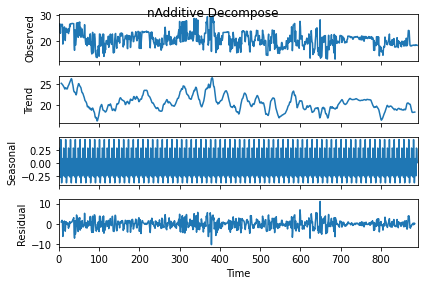

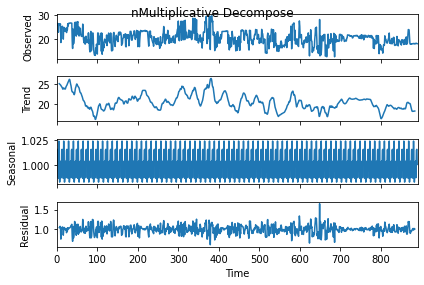

In [150]:

#%%% Decomposition

# Additive and Multiple Decomposition
add_result = seasonal_decompose(purchase, model='additive',freq=12)
add_result.plot().suptitle('nAdditive Decompose', fontsize=12)
# Multiplicative Decomposition 
mul_result = seasonal_decompose(purchase, model='multiplicative',freq=12)
mul_result.plot().suptitle('nMultiplicative Decompose', fontsize=12)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


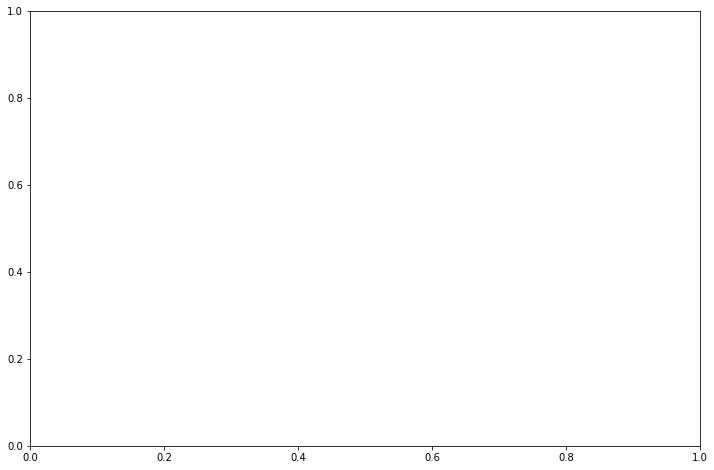

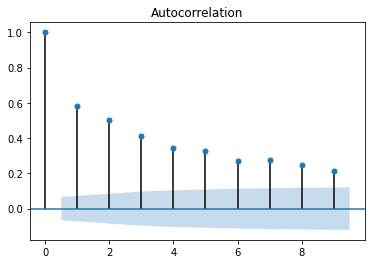

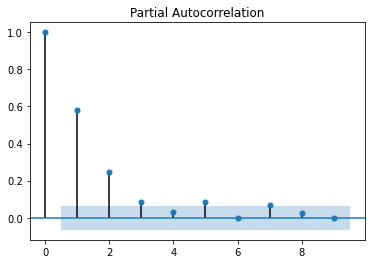

In [152]:


#%%% ACF and PCF Polts
from pandas.plotting import autocorrelation_plot
#pd.plotting.autocorrelation_plot(whole_month)
#plt.show()

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
fig = sm.graphics.tsa.plot_acf(purchase,lags=9)
ax2 = fig.add_subplot()
fig = sm.graphics.tsa.plot_pacf(purchase,lags=9)


#%%% ARIMA Model
from statsmodels.tsa.arima_model import ARIMA


## ARIMA

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  891
Model:                     ARMA(2, 2)   Log Likelihood               -2033.953
Method:                       css-mle   S.D. of innovations              2.371
Date:                Tue, 05 Apr 2022   AIC                           4079.906
Time:                        05:00:32   BIC                           4108.660
Sample:                             0   HQIC                          4090.895
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.6448      0.582     35.451      0.000      19.503      21.786
ar.L1.y        1.6910      0.072     23.469      0.000       1.550       1.832
ar.L2.y       -0.6968      0.069    -10.063      0.0

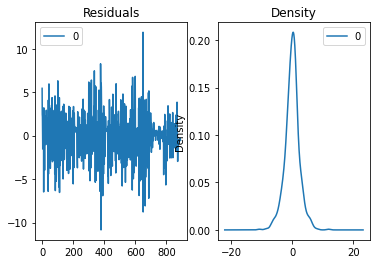

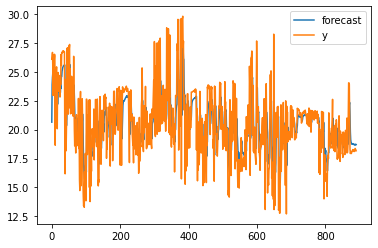

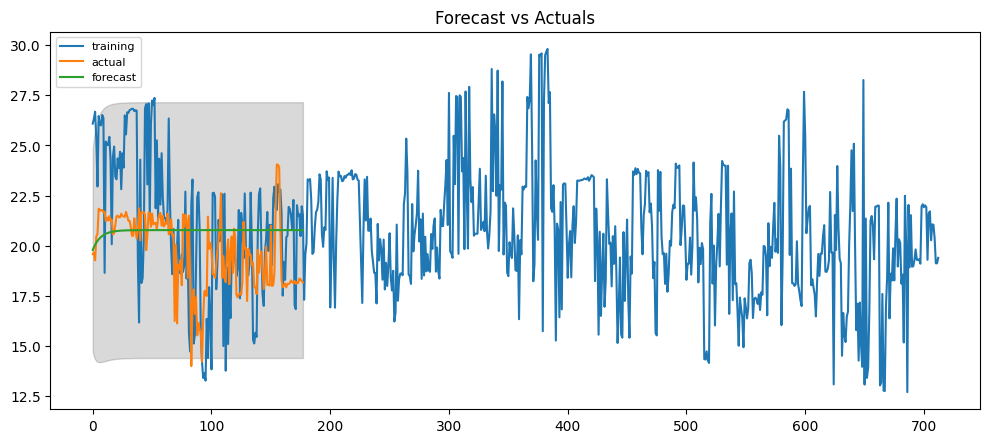

2.111196212716626


In [161]:
# 2,0,2 ARIMA Model - Based on ACF and PCF Plot
model = ARIMA(purchase, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

model_fit.plot_predict(dynamic=False)
plt.show()
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train_price, order=(1, 0, 1))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(len(test_price), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_price, label='training')
plt.plot(test_price, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
plt.clf()

rmse_price_arima = sqrt(mean_squared_error(test_price, fc_series))
print(rmse_price_arima)

In [164]:
rmse_purchase_arima = sqrt(mean_squared_error(test_price, fc_series))
print(rmse_purchase_arima)

mape_purchase_arima = MAPE(test_price, fc_series)
print(mape_purchase_arima)

mse_purchase_arima = MSE(fc_series,test_price)

df_forecast_price["ARIMA"] = fc

df_errors_price.loc["ARIMA","MAPE"] = mape_purchase_arima
df_errors_price.loc["ARIMA","RMSE"] = rmse_purchase_arima
df_errors_price.loc["ARIMA","MSE"] = mse_purchase_arima

2.111196212716626
0.07837619671377258


In [165]:
df_errors_price

,Method,RMSE,MAPE,MSE
seasonalNaiveForecast,NaN,2.438201,0.051832,2.438201
MovingAvging,NaN,1.681295,0.043829,1.681295
Exponential_Smoothing,NaN,2.159874,0.055446,2.159874
Holt_Winters,NaN,3.290178,0.080623,3.290178
ARIMA,NaN,2.111196,0.078376,4.457149


In [168]:

#%%% SARIMAX

model=sm.tsa.statespace.SARIMAX(purchase,order=(1,1, 1),seasonal_order=(1,1,2,10))
results=model.fit()

print(results.summary())

model = sm.tsa.statespace.SARIMAX(train_price, order=(2, 1, 0),seasonal_order=(1,1,0,12))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test_price))  # 95% conf

# Make as pandas series
fc_series = pd.Series(data = fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])
print(fitted.summary())

rmse_price_sarimax = sqrt(mean_squared_error(test_price, fc_series))
print(rmse_price_sarimax)

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  891
Model:             SARIMAX(1, 1, 1)x(1, 1, 2, 10)   Log Likelihood               -2045.529
Date:                            Tue, 05 Apr 2022   AIC                           4103.058
Time:                                    05:04:58   BIC                           4131.738
Sample:                                         0   HQIC                          4114.026
                                            - 891                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3563      0.032     11.171      0.000       0.294       0.419
ma.L1         -0.8992      0.016   

GRID SEARCH

In [ ]:
import itertools

#set parameter range

p = range(0,4)
q= range(0,4)
d = [0, 1, 2]
s = [0,10,26]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
df6=pd.DataFrame(columns=["AIC","Attributes"])
i=0
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_price,order = param, seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            df6.loc[i,"AIC"]=results.aic
            add_list=list(param + param_seasonal)
            df6.loc[i,"Attributes"]=add_list
        except:
            continue
    i=i+1

Optimization terminated successfully.
         Current function value: 4.463670
         Iterations: 1
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 4.463670
         Iterations: 1
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 4.463670
         Iterations: 1
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 3.895531
         Iterations: 2
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 3.948326
         Iterations: 3
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: 3.980403
         Iterations: 3
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 3.542682
         Iterations: 3
         Function evaluations: 112
Optimization terminated successfully.
  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 2.778684
         Iterations: 2
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 2.754258
         Iterations: 3
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 2.583313
         Iterations: 3
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 2.586976
         Iterations: 4
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 2.582507
         Iterations: 3
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 2.583587
         Iterations: 5
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 2.530753
         Iterations: 1
         Function evaluations: 24
Optimization terminated successfully.

## Random Forest

In [ ]:
df_2 = df_price.groupby(['Year','Date']).agg(sum_q=('Quantity',sum),price = ('Rate','mean')).reset_index()

df_2.sort_values(['Year','Date'],inplace =True)

df_3 = df_sales.groupby(['Year','Date']).agg(sum_weight=('Weight',sum),Discount=('Adj_Dis','median'),Unit_Rate = ('Unit_Price_Dis','mean')).reset_index()

df_3[['sum_weight','Unit_Rate']] = df_3[['sum_weight','Unit_Rate']].shift(1,axis=0)
df_randprice = pd.merge(df_3, df_2,on=['Year','Date'] ,how = 'left')

df_randprice.dropna(inplace=True)

del df_randprice['Date']
del df_randprice['Year']
#del df_rand['Product']
#del df_rand['Bag']
labels = np.array(df_randprice['price'])
feature_list = list(df_randprice.columns.values)
                          
del df_randprice['price']
df_randprice = np.array(df_randprice)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_randprice, labels, test_size = 0.2, random_state = 1000)



print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)



# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('Unit_Rate')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors)))


# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf_price = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf_price.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions_price = rf_price.predict(test_features)
# Calculate the absolute errors
errors_price = abs(predictions_price - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape_price_rf = 100 * (errors_price / test_labels)
# Calculate and display accuracy
accuracy_price_rf = 100 - np.mean(mape_price_rf)
print('Accuracy:', round(accuracy_price_rf, 2), '%.')



from sklearn.metrics import mean_squared_error
rmse_price_rf = math.sqrt(mean_squared_error(test_labels, predictions_price))
print('RMSE of Random Forest =',round(rmse_price_rf))

#mape_rf = mape(test_labels,predictions)
#print(mape_rf)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
# Create a based model
rf = RandomForestRegressor()
#Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
#grid_search.best_params_


best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Training Features Shape: (688, 4)
Training Labels Shape: (688,)
Testing Features Shape: (173, 4)
Testing Labels Shape: (173,)
Average baseline error:  176
Mean Absolute Error: 89.0 degrees.
Accuracy: 87.27 %.
RMSE of Random Forest = 3
Model Performance
Average Error: 2.5718 degrees.
Accuracy = 87.23%.


In [ ]:
predictions_price_rf = best_grid.predict(test_features)
mape_purchase_rf = MAPE(predictions_demand_rf,test_labels)
rmse_purchase_rf = math.sqrt(mean_squared_error(test_labels, predictions_demand_rf))
mse_purchase_rf = MSE(predictions_demand_rf,test_labels)

In [ ]:
df_forecast_price["Random_Forest"] = predictions_price_rf

df_errors_price.loc["Random_Forest","MAPE"] = mape_purchase_rf
df_errors_price.loc["Random_Forest","RMSE"] = rmse_purchase_rf
df_errors_price.loc["Random_Forest","MSE"] = mse_purchase_rf

# Optimisation Problem

In [97]:
#Demand and Price Predictions

In [98]:
Price_Predictions = list(fc[-120:])

In [99]:
print(Price_Predictions.count())

TypeError: ignored

In [ ]:
Demand_Predictions = [round(x)*2 for x in (predictions_demand)]
print(Demand_Predictions)

In [ ]:
# Install Pyomo and GLPK
!pip install -q pyomo
!apt-get install -y -qq glpk-utils #if GLPK is used

In [ ]:
from pyomo.environ import *

model = ConcreteModel()

iIndexList = list(range(len(Price_Predictions)))
jIndexList = list(range(4))


# Variables
model.x = Var(iIndexList, within = NonNegativeReals)
model.y = Var(jIndexList, within = NonNegativeReals)

model.pprint()

In [ ]:
# Objective function

obj_expr = sum(Price_Predictions[i] * model.x[(i)] for i in iIndexList)
print(obj_expr)
model.OBJ = Objective(expr = obj_expr, sense = minimize)


In [ ]:
model.constraint1 = ConstraintList()

In [ ]:
model.constraint2 = ConstraintList()

In [ ]:
model.constraint3 = ConstraintList()

In [ ]:
for i in range(0,120,30):
  const_expr = - model.y[(i/30)] + sum(model.x[(k)] for k in range(i,i+30)) >= Demand_Predictions[round(i/30)]
  print(const_expr)
  model.constraint2.add(expr = const_expr)

In [ ]:
for j in range(4):
  const_expr = model.y[j] == 100
  print(const_expr)
  model.constraint1.add(expr = const_expr)

In [ ]:
for i in iIndexList:
  const_expr = model.x[i] <= 160
  print(const_expr)
  model.constraint1.add(expr = const_expr)

In [ ]:
model.pprint()

In [ ]:
# Solve the model
opt = SolverFactory('glpk')
opt.solve(model) 

model.display()